In [37]:
# import os; os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [38]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [39]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU devices found. TensorFlow will run on CPU.")

TensorFlow is using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [40]:
# from google.colab import drive
# drive.mount('/content/drive')

In [41]:
## importing required packages
import numpy as np
from os import listdir
import tensorflow as tf
import keras
from  keras import layers
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

In [42]:
## CONFIGURATION 
EPOCHS = 50
BUFFER_SIZE = 2000
BATCH_SIZE = 1

IMG_HEIGHT = 128
IMG_WIDTH = 128

In [43]:
# image_dir = "/content/drive/My Drive/3d printer/codes/datasets/cropped-datasets/"
# masks_dir = "/content/drive/My Drive/3d printer/codes/datasets/ground-truth/"

image_dir = "./All_images/"
masks_dir = "./All_masks/"

In [44]:
# import glob
# img_files = glob.glob(image_dir + '/**/*.jpg', recursive=True)
# mask_files = glob.glob(masks_dir + '/**/*.png', recursive=True)
# img_files[:10], mask_files[:10]

In [45]:
# choose on of the pairs of data and mask for dataset

img_folders = ['abyek_images', 'Khorasan_part1_images', 'Khorasan_part2_images', 'bound_images', 'France_images', 'orthophoto_images']
mask_folders = ['abyek_masks', 'Khorasan_part1_masks', 'Khorasan_part2_masks', 'bound_masks', 'France_masks', 'orthophoto_masks']

# img_folders = ['abyek_images', 'Khorasan_part1_images', 'Khorasan_part2_images']
# mask_folders = ['abyek_masks', 'Khorasan_part1_masks', 'Khorasan_part2_masks']

# img_folders = ['abyek_images', 'Khorasan_part1_images',  'deliniation_images', 'bound_images']
# mask_folders = ['abyek_masks', 'Khorasan_part1_masks', 'deliniation_masks', 'bound_masks']

# img_folders = ['abyek_images']
# mask_folders = ['abyek_masks']


images_path, masks_path = [], []
# loop in pair of data and mask to make list of images and masks based on folder image
for fol, mfol in zip(img_folders, mask_folders):
    images_list = listdir(image_dir + fol)
    masks_list = listdir(masks_dir + mfol)

    img_list = [i.split('.jpg')[0] for i in images_list]
    msk_list = [i.split('.png')[0] for i in masks_list]

    commons = list(set(img_list) & set(msk_list))

    shuffle(commons)
    
    commons = commons[:1200]

    print(len(commons))

    ip =  [image_dir + fol + "/" + i + ".jpg"  for i in commons]
    mp  = [masks_dir + mfol + "/" + i + ".png"  for i in commons]
    # print(len(ip), len(mp))

    images_path.extend(ip)
    masks_path.extend(mp)
    # print(len(images_path), len(masks_path))

1155
1001
1200
1200
1200
1200


In [46]:
images_path[:10], masks_path[:10] 

(['./All_images/abyek_images/452.jpg',
  './All_images/abyek_images/964.jpg',
  './All_images/abyek_images/43.jpg',
  './All_images/abyek_images/671.jpg',
  './All_images/abyek_images/1046.jpg',
  './All_images/abyek_images/1635.jpg',
  './All_images/abyek_images/1595.jpg',
  './All_images/abyek_images/206.jpg',
  './All_images/abyek_images/292.jpg',
  './All_images/abyek_images/1185.jpg'],
 ['./All_masks/abyek_masks/452.png',
  './All_masks/abyek_masks/964.png',
  './All_masks/abyek_masks/43.png',
  './All_masks/abyek_masks/671.png',
  './All_masks/abyek_masks/1046.png',
  './All_masks/abyek_masks/1635.png',
  './All_masks/abyek_masks/1595.png',
  './All_masks/abyek_masks/206.png',
  './All_masks/abyek_masks/292.png',
  './All_masks/abyek_masks/1185.png'])

In [47]:
def load_images(image_path, mask_path, img_size = (IMG_HEIGHT, IMG_WIDTH)):
  # load our images from the image and mask path
  img_data = tf.io.read_file(image_path)
  img = tf.io.decode_png(img_data,channels=3)
  img = tf.image.convert_image_dtype(img,tf.float32)

  segm_data = tf.io.read_file(mask_path)
  mask = tf.io.decode_png(segm_data)
  mask = tf.math.reduce_max(mask, axis = -1, keepdims=True)
  mask = mask / 255

  img = tf.image.resize(img, img_size , method = 'nearest')
  mask = tf.image.resize(mask, img_size, method = 'nearest')
  
  return img, mask

In [48]:
dataset = tf.data.Dataset.from_tensor_slices((images_path, masks_path))
dataset = dataset.map(load_images ,num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(BUFFER_SIZE)

In [49]:
def compute_sample_weights(image, mask):
	''' Compute sample weights for the image given class. '''
	# Compute relative weight of class
	class_weights = tf.constant([1., 8.0])
	class_weights = class_weights/tf.reduce_sum(class_weights)

  	# Compute same-shaped Tensor as mask with sample weights per
  	# mask element. 
	sample_weights = tf.gather(class_weights, indices=tf.cast(mask, tf.int32))

	return image, mask, sample_weights

In [50]:
seed = 123
# divide our dataset into training and test set
val_dataset = (dataset
               .take(500)
               .prefetch(buffer_size=tf.data.AUTOTUNE) 
               )
train_dataset = (dataset
                .skip(500)
                .map(lambda image, mask: (tf.image.random_flip_up_down(image, seed=seed), tf.image.random_flip_up_down(mask, seed=seed)))
                .map(lambda image, label: (tf.image.random_flip_left_right(image, seed=seed), tf.image.random_flip_left_right(label, seed=seed)))
                .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=0.8), label))               
                .map(compute_sample_weights)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
                .repeat(5)
                ) 
# train_dataset = train_dataset.map(lambda image, mask: (tf.image.random_flip_up_down(image, seed=seed), tf.image.random_flip_up_down(mask, seed=seed))).repeat(1)

In [51]:
train_dataset.cardinality().numpy()

32280

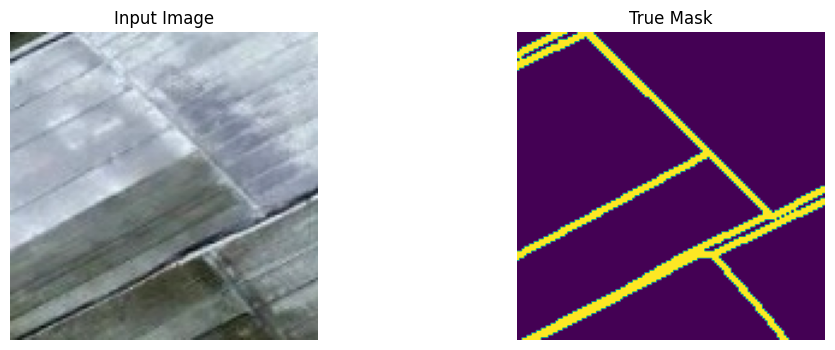

In [52]:
# plot images
def display(display_list, num_plot, flag=False):
  plt.figure(figsize=(12, 4))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  if flag:
    plt.savefig(f"./Result_plots/result_img_resunet_{num_plot}.png")
    
N = 1
for image,mask in dataset.take(N):
  sample_image, sample_mask = image[0],mask[0]
  display([sample_image,sample_mask], False)
  

## ResUnet Model

In [53]:
def bn_act(x, act=True):
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tf.keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tf.keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = tf.keras.layers.UpSampling2D((2, 2))(x)
    c = tf.keras.layers.Concatenate()([u, xskip])
    return c

In [54]:
def ResUNet():
    f = [8, 16, 32, 64, 128]
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [55]:
model = ResUNet()

In [56]:
from tensorflow.keras.optimizers import Adam
import keras.backend as K



def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# calculate iou metric
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def weighted_binary_crossentropy(y_true, y_pred):
	zero_weight=1
	one_weight=4
	b_ce = K.binary_crossentropy(y_true, y_pred)
	weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
	weighted_b_ce = weight_vector * b_ce
	return K.mean(weighted_b_ce)

def dice_binary_crossentropy(y_true, y_pred):
    zero_weight=1
    one_weight=10
    b_ce = K.binary_crossentropy(y_true, y_pred)
    dicloss = 1 - dice_coeff(y_true, y_pred)
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce * dicloss
    return K.mean(weighted_b_ce)


# compile the model 
model.compile(
     optimizer=Adam(learning_rate=0.001),
        # loss="binary_crossentropy",
        loss=weighted_binary_crossentropy,
        # loss=dice_binary_crossentropy,
        metrics=["accuracy", "Precision", "Recall", f1_score],
        # sample_weight_mode="temporal",
  )

In [57]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 128, 128, 8)  224         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_28 (BatchN  (None, 128, 128, 8)  32         ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [58]:
callbacks = [
    # ReduceLROnPlateau(patience=3, verbose=1),
    # EarlyStopping(patience=12, verbose=1),
    ModelCheckpoint('ResUnet-bce4-model.h5', verbose=0, save_freq="epoch", save_best_only=True,save_weights_only=False)
    ]

In [59]:
  # fiting the model
history = model.fit(
      train_dataset,
      epochs=EPOCHS,
      validation_data = val_dataset,
      # validation_steps = 8,
      # batch_size=BATCH_SIZE,
      callbacks = callbacks, 
    )

Epoch 1/50
32280/32280 [==============================] - 492s 15ms/step - loss: 0.0968 - accuracy: 0.8805 - precision: 0.3259 - recall: 0.5328 - f1_score: 0.3035 - val_loss: 0.5275 - val_accuracy: 0.9303 - val_precision: 0.5086 - val_recall: 0.1465 - val_f1_score: 0.2022
Epoch 2/50
32280/32280 [==============================] - 487s 15ms/step - loss: 0.0878 - accuracy: 0.8860 - precision: 0.3539 - recall: 0.6029 - f1_score: 0.3406 - val_loss: 0.6065 - val_accuracy: 0.9339 - val_precision: 0.5233 - val_recall: 0.0650 - val_f1_score: 0.1002
Epoch 3/50
32280/32280 [==============================] - 488s 15ms/step - loss: 0.0836 - accuracy: 0.8891 - precision: 0.3674 - recall: 0.6317 - f1_score: 0.3579 - val_loss: 0.4988 - val_accuracy: 0.9328 - val_precision: 0.5288 - val_recall: 0.1662 - val_f1_score: 0.2135
Epoch 4/50
32280/32280 [==============================] - 490s 15ms/step - loss: 0.0800 - accuracy: 0.8922 - precision: 0.3796 - recall: 0.6548 - f1_score: 0.3723 - val_loss: 0.4938

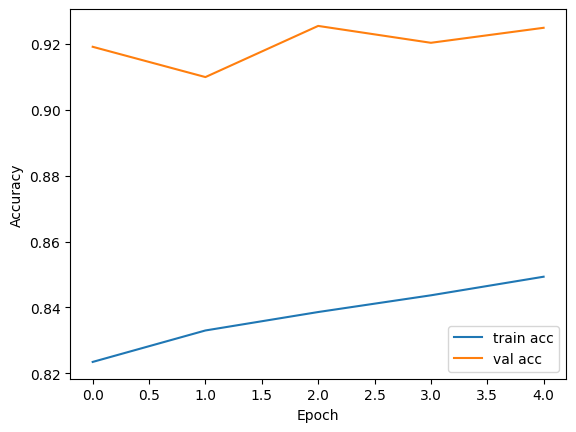

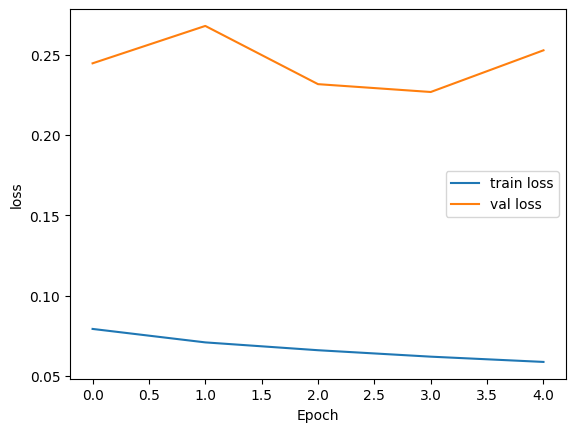

In [ ]:
# plot the accuracy and loss plots for train and test data

plt.plot(history.history["accuracy"], label='train acc')
plt.plot(history.history["val_accuracy"], label='val acc')
# plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"./Result_plots/result_resunet_acc.png")
plt.show()

plt.plot(history.history["loss"], label='train loss')
plt.plot(history.history["val_loss"], label='val loss')
# plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig(f"./Result_plots/result_resunet_loss.png")
plt.show()

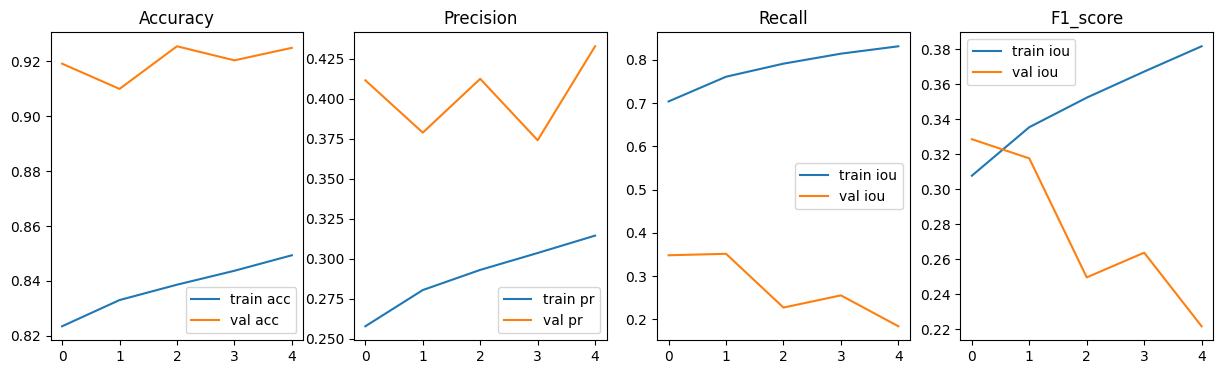

In [ ]:
# plot accuracy, precision and IOU  

fig , ax = plt.subplots(1, 4, figsize=(15, 4))

ax[0].plot(history.history["accuracy"], label='train acc')
ax[0].plot(history.history["val_accuracy"], label='val acc')
ax[0].set_title('Accuracy')
ax[0].legend()

ax[1].plot(history.history["precision"], label='train pr')
ax[1].plot(history.history["val_precision"], label='val pr')
ax[1].set_title('Precision')
ax[1].legend()

ax[2].plot(history.history["recall"], label='train iou')
ax[2].plot(history.history["val_recall"], label='val iou')
ax[2].set_title('Recall')
ax[2].legend()

ax[3].plot(history.history["f1_score"], label='train iou')
ax[3].plot(history.history["val_f1_score"], label='val iou')
ax[3].set_title('F1_score')
ax[3].legend()

plt.savefig(f"./Result_plots/result_resunet_final.png")
plt.show()

In [ ]:
def create_mask(pred_mask):
    # pred_mask = tf.argmax(pred_mask, axis=-1)
    pred = pred_mask[0]
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0

    # pred_mask = pred_mask[..., tf.newaxis]
    return pred

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        counter = 0
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image, verbose=0)
            # print(pred_mask[0][pred_mask[0]>0.5])
            display([image[0], mask[0], create_mask(pred_mask)], counter, True)
            counter += 1
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

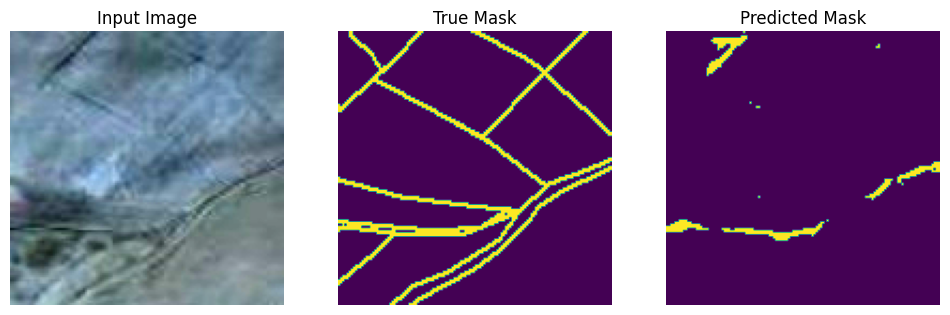

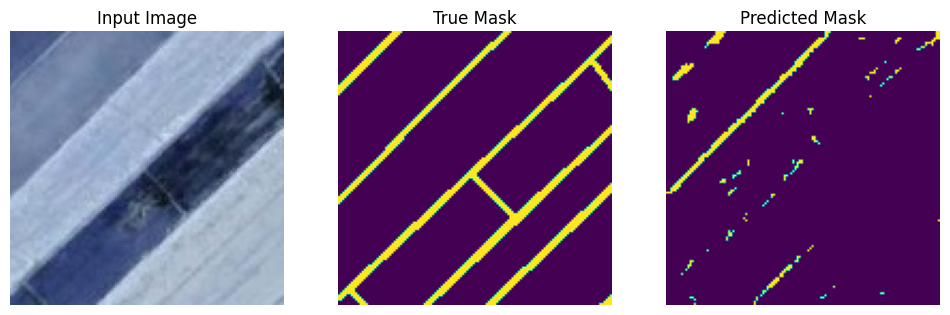

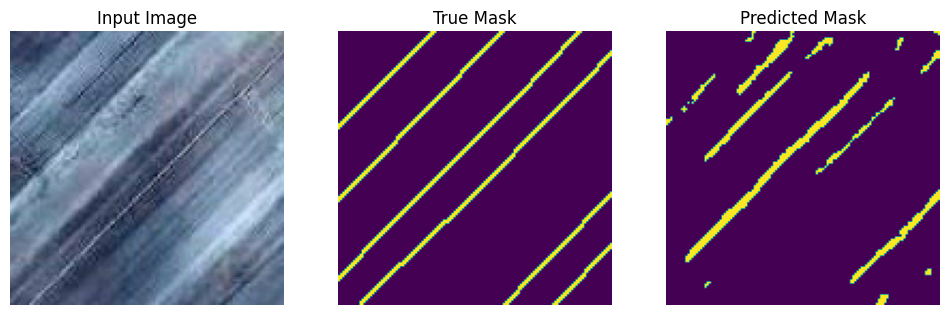

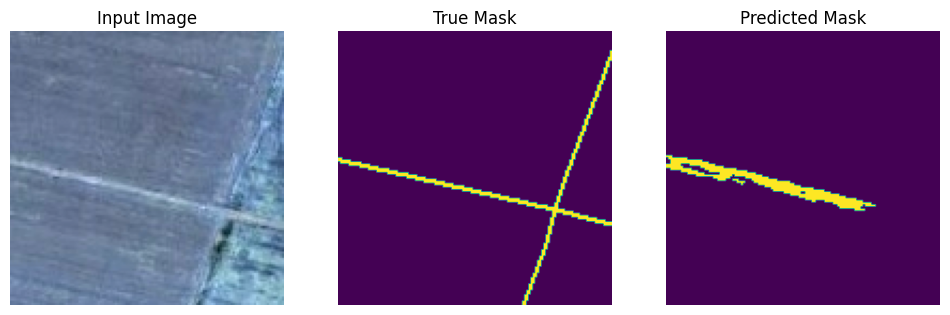

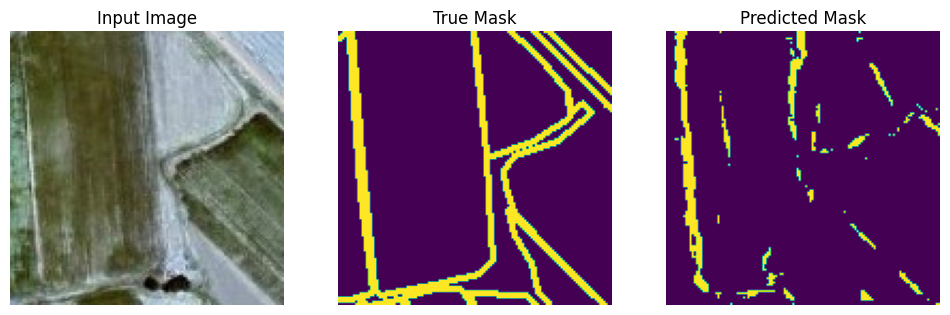

In [ ]:
## displaying our result
show_predictions(val_dataset,num=5)